## Import Libraries

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_recall_curve

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

## Load Data

In [2]:
# Load Data
df = pd.read_csv('C:/Users/Acer/Downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## EDA (Exploratory Data Analysis)

In [3]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [4]:
# Change TotalCharges column type
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [6]:
df = df.drop(columns=['customerID'])

In [7]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])

In [8]:
df_numeric.corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.016567,0.220173,0.102411
tenure,0.016567,1.000000,0.247900,0.825880
MonthlyCharges,0.220173,0.247900,1.000000,0.651065
TotalCharges,0.102411,0.825880,0.651065,1.000000


SeniorCitizen vs tenure = 0.016567 → Almost no correlation.

SeniorCitizen vs MonthlyCharges = 0.220173 → Weak positive correlation.

tenure vs MonthlyCharges = 0.247900 → Weak positive correlation.

tenure vs TotalCharges = 0.8259 → strong positive correlation. The longer the tenure, the more total charges (makes sense: charges accumulate over time).

MonthlyCharges vs TotalCharges = 0.6511 → moderately strong correlation. Higher monthly bills → higher total charges.

In [9]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [10]:
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

## Coding Categorical columns

In [11]:
df.Contract.value_counts()

Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

In [12]:
# Encode target
df['Churn'] = LabelEncoder().fit_transform(df['Churn'])

In [13]:
# Encode Contract (ordinal)
contract_map = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
df['Contract'] = df['Contract'].map(contract_map)

In [14]:
# One-hot encode all other categorical variables
df = pd.get_dummies(df, columns=[
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'PaperlessBilling', 'PaymentMethod'
], dtype=int)


In [15]:
df.head()

,SeniorCitizen,tenure,Contract,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,...,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,29.85,29.85,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,1,56.95,1889.50,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
2,0,2,0,53.85,108.15,1,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0,45,1,42.30,1840.75,0,0,1,1,0,...,0,1,0,0,1,0,1,0,0,0
4,0,2,0,70.70,151.65,1,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


In [16]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())

## Modeling

In [17]:
X = df.drop(columns=['Churn'])    # features
y = df['Churn']                   # target

In [18]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Train a model (Logistic Regression)

In [19]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

C:\Users\Acer\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

## Make predictions

In [20]:
y_pred = lr_model.predict(X_test)

## Evaluate the model

In [21]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8041163946061036
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409



Model has good accuracy (80%), but it’s biased toward class 0.

It predicts class 0 well, but class 1 recall is low (misses 44% of class 1).

## Train a model (Decision Tree)

In [22]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [23]:
# Make predictions
y_pred_dt = dt_model.predict(X_test)

In [24]:
# Evaluate the dt_model
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Accuracy: 0.7253371185237757
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1035
           1       0.48      0.50      0.49       374

    accuracy                           0.73      1409
   macro avg       0.65      0.65      0.65      1409
weighted avg       0.73      0.73      0.73      1409



The Decision Tree achieved an accuracy of 72.5%, which is lower than Logistic Regression (80%).

It performs well on class 0 (precision 0.82, recall 0.81, F1 = 0.81).

It performs poorly on class 1 (precision 0.48, recall 0.50, F1 = 0.49), meaning the model misses many minority-class cases.

This shows the model is biased toward the majority class (0) because of class imbalance.

Overall, the Decision Tree is not the best choice here without tuning or balancing.

## Train a model (Random Forest)

In [27]:
# Train model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [28]:
y_pred_rf = rf_model.predict(X_test)

In [30]:
# Evaluate the dt_model
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.7828246983676366
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409



The Random Forest model achieves high overall accuracy (78.3%) but performs poorly on the minority class, with a low recall of 48%. This indicates a significant class imbalance issue that needs to be addressed to improve model fairness and effectiveness.

## Using GridSearchCV for RandomForest

In [34]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

In [35]:
# Grid search
grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro',
                           n_jobs=-1,
                           verbose=1)

In [36]:
# Fit to training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1_macro', verbose=1)

In [38]:
best_rf_model = grid_search.best_estimator_

In [39]:
y_pred_rf = best_rf_model.predict(X_test)

In [40]:
# Print classification report
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.8034066713981547
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



After tuning the Random Forest model using GridSearchCV, the accuracy improved to 80.3%, and the F1-score for the minority class increased from 0.54 to 0.58. While the model still favors the majority class, the enhanced balance in precision and recall indicates that hyperparameter optimization has led to a more effective and fairer classification.

## Gradient Boosting

In [54]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')


In [55]:
# Train
xgb_model.fit(X_train, y_train)

C:\Users\Acer\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:20:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [56]:
# Predict
y_pred_xgb = xgb_model.predict(X_test)

In [57]:
# Evaluate the dt_model
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Accuracy: 0.7764371894960965
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.59      0.52      0.55       374

    accuracy                           0.78      1409
   macro avg       0.71      0.70      0.70      1409
weighted avg       0.77      0.78      0.77      1409



After applying XGBoost (XGBClassifier), the model achieved an accuracy of 77.6%, with a slight improvement in recall (52%) and F1-score (0.55) for the minority class compared to the initial Random Forest. While overall accuracy is slightly lower than the GridSearch-tuned Random Forest, XGBoost shows better balance between precision and recall, making it a competitive alternative for handling class imbalance.

### XGBClassifier GridSearchCV

In [59]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 3, 5],
}


In [61]:
# Grid search
grid_search_xgb = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid_xgb,
                           cv=5,
                           scoring='f1_macro',
                           n_jobs=-1,
                           verbose=1)

In [62]:
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


C:\Users\Acer\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:24:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 1, 5],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 10], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='f1_macro', verbose=1)

In [63]:
best_xgb_model = grid_search_xgb.best_estimator_

In [64]:
y_pred_xgb = best_xgb_model.predict(X_test)

In [66]:
# Print classification report
print("Best Parameters:", grid_search_xgb.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.8069552874378992
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



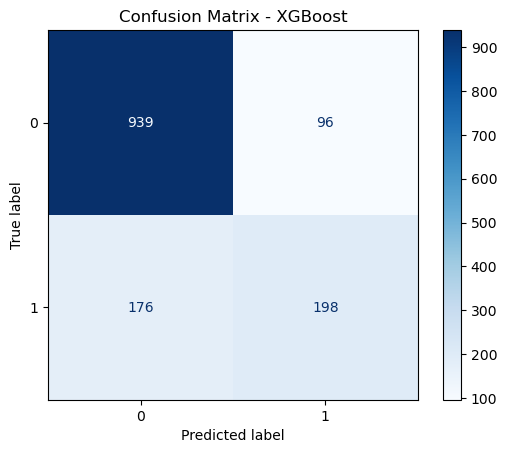

In [81]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.show()

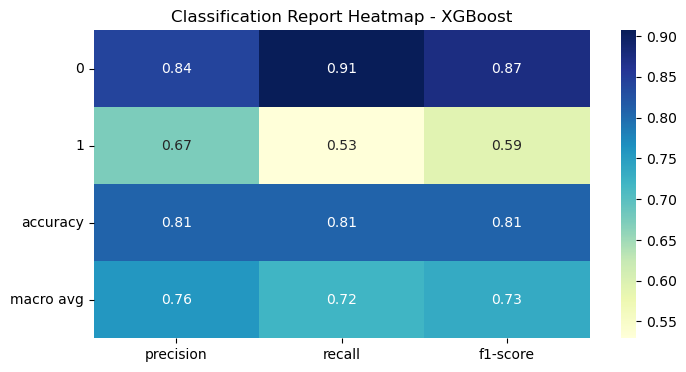

In [83]:
# Convert classification report to DataFrame
report = classification_report(y_test, y_pred_xgb, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plot as heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Classification Report Heatmap - XGBoost')
plt.yticks(rotation=0)
plt.show()


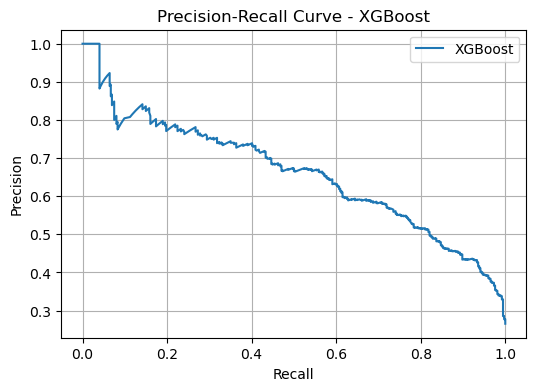

In [86]:
# If using XGBClassifier, use predict_proba
y_scores = grid_search_xgb.best_estimator_.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost')
plt.grid(True)
plt.legend()
plt.show()


After hyperparameter tuning with GridSearchCV, the XGBoost model achieved higher accuracy (80.7%) and improved minority class performance, particularly in F1-score (0.59) and recall (53%), compared to the untuned version. This indicates the model is now better balanced and more effective in identifying the underrepresented class.

## Support Vector Machine

In [73]:
# svc_model = SVC(kernel='rbf', probability=True)
svc_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svc_model.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [74]:
y_pred_svc = svc_model.predict(X_test)

In [75]:
# Evaluate the dt_model
print("Accuracy:", accuracy_score(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))

Accuracy: 0.6699787083037615
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1035
           1       0.41      0.59      0.49       374

    accuracy                           0.67      1409
   macro avg       0.62      0.65      0.62      1409
weighted avg       0.72      0.67      0.69      1409



The SVM model (SVC) achieved an overall accuracy of 66.99%, which is significantly lower than Random Forest and XGBoost models. However, it showed an improved recall of 59% for the minority class (class 1), which means it was better at identifying positive cases, albeit at the cost of lower precision and overall accuracy. This trade-off suggests SVM may be more suitable if recall for the minority class is a higher priority, but overall, it underperforms compared to ensemble models in this task.

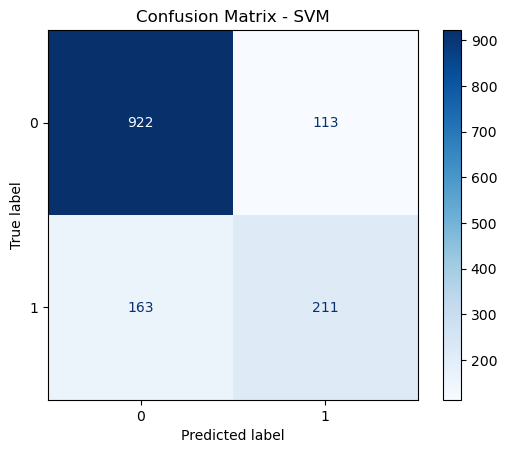

In [79]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Plot
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.show()

## Scale Features (Important for SVM)


In [77]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svc_model.fit(X_train_scaled, y_train)
y_pred_svc = svc_model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))


Accuracy: 0.7409510290986515
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



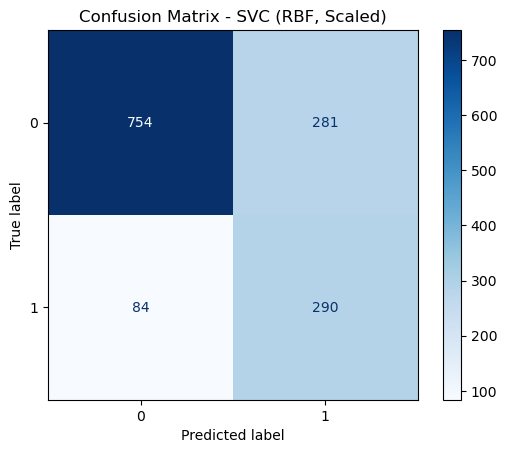

In [84]:
cm = confusion_matrix(y_test, y_pred_svc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - SVC (RBF, Scaled)')
plt.show()

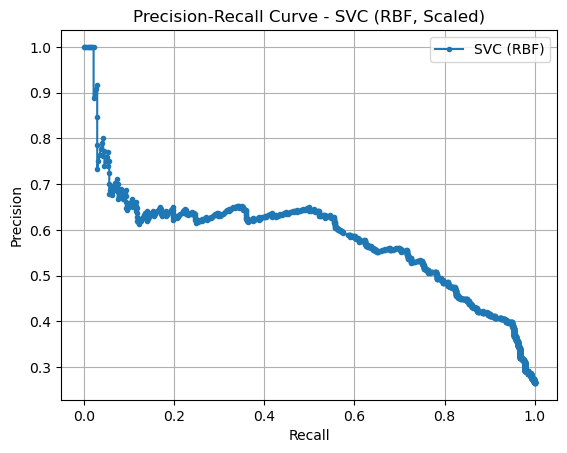

In [85]:
# Get probability scores for class 1
y_scores_svc = svc_model.predict_proba(X_test_scaled)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores_svc)

plt.plot(recall, precision, marker='.', label='SVC (RBF)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVC (RBF, Scaled)')
plt.grid(True)
plt.legend()
plt.show()


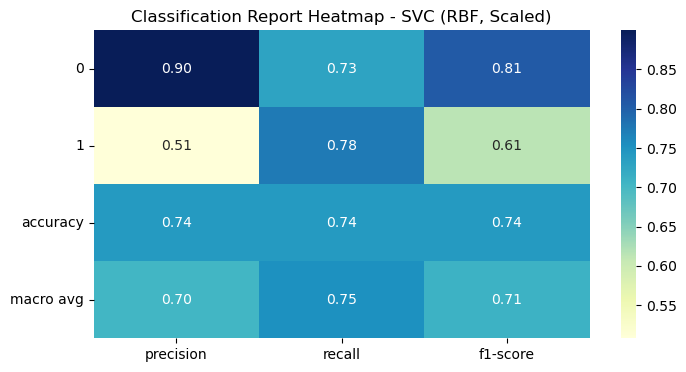

In [89]:
# Convert classification report to DataFrame
report = classification_report(y_test, y_pred_svc, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Classification Report Heatmap - SVC (RBF, Scaled)')
plt.yticks(rotation=0)
plt.show()

Using StandardScaler and class_weight='balanced' with an RBF kernel SVM significantly improved the recall of the minority class (from 59% to 78%), making it much better at identifying positive cases. However, this came with a drop in overall accuracy (to 74%) and lower precision for class 1 (more false positives). This trade-off is valuable in scenarios where recall for the minority class is more important than overall accuracy — e.g., fraud detection, disease diagnosis, etc.

## Conclusions

### General Model Evaluation Conclusion (List Format):

#### XGBoost (with GridSearchCV)

✅ Best overall performance.

Highest accuracy (~80.7%).

Balanced performance across both classes.

Good F1-score for class 1.

Recommended when you need both accuracy and fairness across classes.

#### SVM (with scaling and class_weight='balanced')

✅ Best recall for the minority class (78%).

Lower overall accuracy (~74.1%) but identifies more true positives from class 1.

Ideal when missing class 1 predictions is costly (e.g., fraud detection, health risk).

#### Logistic Regression

Solid accuracy (~80.4%) and decent minority class recall (56%).

Performs close to XGBoost with added benefit of being interpretable.

Great baseline model or when explainability is a requirement.

#### Random Forest (tuned with GridSearchCV)

Accuracy close to XGBoost (~80.3%).

Minority class recall is lower (52%), but still respectable.

Suitable for general use, but slightly edged out by XGBoost in performance.

#### Decision Tree (untuned)

❌ Lowest performance overall (accuracy ~72.5%).

Struggles with class imbalance; biased toward the majority class.

Not recommended in its current form unless significantly tuned or combined with resampling methods.